In [92]:
import albumentations as A
import cv2
import random
from matplotlib import pyplot as plt
import numpy as np
import PIL
from PIL import Image
import numpy
import numpy.ma as ma
from numpy import asarray
import os
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [93]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [94]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('NO GPU found, CPU is used')
  # Invalid device or cannot modify virtual devices once initialized.
    pass


NO GPU found, CPU is used


2
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[2 2 2]
 [2 2 2]
 [2 2 2]
 ...
 [2 2 

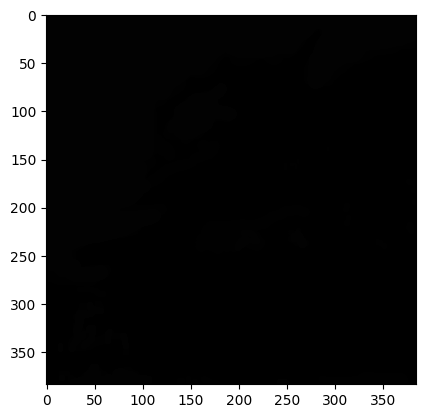

In [95]:
img=cv2.imread('C:\\Users\\ale8p\\OneDrive\\Escritorio\\HACKATHON\\image_1_fullmask.png')
img_array = np.asarray(img, dtype='int32')
print(np.max(img_array))
for row in img_array:
    print(row)
plt.imshow(img_array, interpolation='nearest')

In [96]:
class TrainDataGenerator:

    def __init__(self, image_list: list[str], mask_list: list[str], width: int, height: int,
                 batch_size: int, augmentor: A):
        self.image_list = image_list
        self.mask_list = mask_list
        self.width = width
        self.height = height
        self.batch_size = batch_size
        self.augmentor = augmentor

    def __str__(self):
        return f'TrainDataGenerator({self.image_list}, {self.mask_list},{self.width},{self.height}, {self.batch_size}, {self.augmentor})'

    def __repr__(self):
        return f'TrainDataGenerator'

    @property
    def data(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_list, self.mask_list))
        dataset = dataset.map(self._read_image, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset

    @property
    def augmented_data(self):
        augmented = self.data.map(
            lambda x, y: tf.numpy_function(self.augment_image, [x, y], [tf.float32, tf.float32]))
        augmented = augmented.map(
            lambda x, y: (
                tf.ensure_shape(x, (self.height, self.width, 3)),
                tf.ensure_shape(y, (self.height, self.width, 3))
            )
        )
        return augmented

    @property
    def data_batched(self):
        return self.data.batch(self.batch_size, drop_remainder=True)

    @property
    def augmented_data_batched(self):
        return self.augmented_data.batch(self.batch_size, drop_remainder=True)

    #@staticmethod
    def augment_image(self,image, mask):
        # Apply the augmentation pipeline to the image
        augmented = self.augmentor(image=image, mask=mask)

        image_aug = augmented['image']
        mask_aug = augmented['mask']
        return [image_aug, mask_aug]

    @tf.autograph.experimental.do_not_convert
    def _read_image(self, image_path: str, mask_path: str):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(
            images=image,
            size=[self.height, self.width],
            method='bilinear',
            preserve_aspect_ratio=False,
            antialias=False,
            name=None
        )
        # grayscale
        #image = tf.image.rgb_to_grayscale(image)
        # rescale image
        image /= 255.

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask.set_shape([None, None, 1])
        mask = tf.image.resize(
            images=mask,
            size=[self.height, self.width],
            method='bilinear',
            preserve_aspect_ratio=False,
            antialias=False,
            name=None
        )
        #mask = tf.where(mask > 0.0, tf.reduce_max(mask), 0)
        mask = tf.cast(mask, tf.int8)

        from tensorflow.keras.utils import to_categorical
        mask = to_categorical(mask, num_classes=3)
        
        # rescale mask
        #mask /= 255.
        return image, mask


In [97]:
def create_overlay(image, prediction, defect_dict: dict, contour=True):
    pred = threshold(prediction, [0.6,0.25, 0.25])

    # colorize masks
    pred_c = color_masks(pred, defect_dict)

    if contour:
        # convert masks into contour
        pred_c = mask2contour(pred_c)

    # create overlay
    overlay_prediction = np.where(pred_c != 0, pred_c, image)

    return overlay_prediction

In [98]:
def threshold(class_prob, class_thresholds):

    prediction = np.zeros_like(class_prob)
    for c, ct in zip(range(class_prob.shape[-1]), class_thresholds):
        prediction[:, :, c] = np.where(class_prob[:, :, c] > ct, 1, 0)
    return np.argmax(prediction, axis=2)

In [99]:
def color_masks(predicted_mask, defect_dict):
    r = np.zeros_like(predicted_mask).astype(np.uint8)
    g = np.zeros_like(predicted_mask).astype(np.uint8)
    b = np.zeros_like(predicted_mask).astype(np.uint8)

    for defect, color in defect_dict.items():
        # create a boolean_mask based on pixel values
        filter_mask = (predicted_mask == defect)
        # assign to each color channel the corresponding
        # pixel value for each defect_class
        r[filter_mask] = color[0]
        g[filter_mask] = color[1]
        b[filter_mask] = color[2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [100]:
def infer(model, image_tensor):

    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    return predictions

In [101]:
transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=40, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5),
    ], p=0.8)])


In [102]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('NO GPU found, CPU is used')
  # Invalid device or cannot modify virtual devices once initialized.
    pass


NO GPU found, CPU is used


In [103]:
HEIGHT = 384
WIDTH = 384
BATCH_SIZE = 3
BATCH_SIZE_VAL = 3
NUM_CLASSES = 3

DATA_DIR = r'C:\Users\ale8p\OneDrive\Escritorio\HACKATHON'

defect_dict = {0: [0., 0., 0.], # black
               1: [1., 0., 0.], # red
               2: [0., 1., 0.], # green
               3: [0., 0., 1.], # blue,
               4: [1., 1., 0.], # yellow
              }

In [104]:
images = glob.glob(os.path.join(DATA_DIR, '*.png'))

# sort out images without defect for training 
defect_images = []
for image in images:    
    defect = re.search('(?<=image_).', image)
    if defect.group(0) != '0':
        defect_images.append(image)
# save masks path into list
original_images = list({path.replace('_fullmask', '_pleiades') for path in defect_images})
original_images.sort()
masks = []
for path in defect_images:
    if path not in original_images:
        masks.append(path)
masks.sort()
# split dataset
train_images, val_images, train_masks, val_masks = train_test_split(original_images, masks, test_size=0.3, random_state=42)

In [105]:
training = TrainDataGenerator(train_images, train_masks, WIDTH, HEIGHT, BATCH_SIZE,transform)
validation  = TrainDataGenerator(val_images, val_masks, WIDTH, HEIGHT, BATCH_SIZE_VAL,transform)

In [106]:
loss = keras.losses.CategoricalCrossentropy()
optm = keras.optimizers.Adam(learning_rate=0.001)

In [107]:
model = sm.Unet('resnet34', input_shape=(512,512,3), classes=3, activation='softmax')
model.compile('Adam', loss=loss, metrics=['accuracy'])

In [108]:
image_no = 5
for idx, (img, msk) in enumerate(training.data):
    if idx == image_no:
        break

In [109]:
msk = training.mask_list[image_no]
msk = Image.open(msk)
msk = np.array(msk)

In [121]:
for a,b in training.data:
    data = (255*np.squeeze(b))
    img = Image.fromarray(data, 'RGB')
    img.show()
    break

In [122]:
training.data

<_ParallelMapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 384, 1, 3), dtype=tf.float32, name=None))>

In [ ]:
history = model.fit(
   training.augmented_data_batched,
   validation_data=validation.augmented_data_batched,
   callbacks=[],
   epochs=30,
)

In [ ]:
img = np.asarray(Image.open(r'C:\Users\ale8p\OneDrive\Escritorio\testing_img\Testing\img_spain_55.jpg'))
img = np.asarray(Image.open(r"C:\Users\ale8p\OneDrive\Escritorio\HACKATHON\testing\img1.png"))
img = img[:,0:512,:]
pre = infer(model=model, image_tensor=img/255)

In [ ]:
fig = make_subplots(rows=1, cols=4)
fig.add_trace(go.Heatmap(z=pre[:,:,0], showlegend=False, showscale=False), row=1, col=1)
fig.add_trace(go.Heatmap(z=pre[:,:,1], showlegend=False, showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=pre[:,:,2], showlegend=False, showscale=False), row=1, col=3)
fig.add_trace(go.Image(z=img), row=1, col=4)
#fig.update_layout(width=2000, height=800)


fig.for_each_xaxis(lambda x: x.update({'scaleanchor': 'y', 'range': [0, 512]}))
fig.for_each_yaxis(lambda x: x.update({'range': [0, 512], 'autorange': "reversed"}))

fig.show()